In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from math import pow

In [18]:
mi= 0.015
CN=10
n=2
D_aTc=0.67*60
D_AHL=10
Nmax=200
Vecoli=10**(-9)
Vbead=200*10**(-6)
Vc=Vecoli/Vbead
d_aTc=0.034/60
d_mrnatetr=0.023#*60
d_tetr=0.0692
d_ahl=0.01
d_mrnaluxi=0.347
d_luxi=0.00167
d_cmplx=0.025
kluxi=25*60*10**(-3)
kA= 0.04 #0.04
NA=6.2*10**(23)
k_min_one=4.2*10**(-4)
kd_cmplx=15 #*10**(-9) 
kd_ptet=50 #*10**(-9)
k1=k_min_one/kd_cmplx
#k1=5.8
b_ptet=0
ptet=25.3*60*10**(-3)
p_105=30*60*10**(-3)
k_034=11*60*10**(-3)
t=np.linspace(0, 1000)

In [3]:
def single_cell(x,t): 
    aTc=x[0]
    TetR=x[1]
    cmplx=x[2]
    LuxI=x[3]
    AHL=x[4]
    
    daTcdt=small+k_min_one*cmplx-(d_aTc+mi)*aTc-k1*aTc*TetR
    dTetRdt=small+(p_105*k_034*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(ptet*kluxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(kd_ptet*CN),n))/((pow(abs(TetR),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI -kA*LuxI
    dAHLdt=small+kA*LuxI-(d_ahl+mi)*AHL
    
    return [daTcdt,dTetRdt,dcmplxdt,dLuxIdt,dAHLdt]

def whole_cell(x,t): 
    N=x[0]
    aTc_ext=x[1]
    aTc_int=x[2]
    TetR=x[3]
    cmplx=x[4]
    LuxI=x[5]
    AHL_int=x[6]
    AHL_ext=x[7]
    
    dNdt=small+mi*N*(1-(N/Nmax))
    daTc_extdt=small+D_aTc*N*(aTc_int-Vc*aTc_ext)-(d_aTc+mi)*aTc_ext
    daTc_intdt=small+D_aTc*(Vc*aTc_ext-aTc_int)+k_min_one*cmplx-(d_aTc+mi)*aTc_int-k1*aTc_int*TetR
    dTetRdt=small+(p_105*k_034*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc_int-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc_int-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(ptet*kluxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(kd_ptet*CN),n))/((pow(abs(TetR),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI -kA*LuxI
    dAHL_intdt=small+kA*LuxI-(d_ahl+mi)*AHL_int+D_AHL*(Vc*AHL_ext-AHL_int)
    dAHL_extdt=small+D_AHL*N*(AHL_int-Vc*AHL_ext)-(d_ahl+mi)*AHL_ext
    
    return [dNdt,daTc_extdt,daTc_intdt,dTetRdt,dcmplxdt,dLuxIdt,dAHL_intdt,dAHL_extdt]

def molecules(number): #turns nM to molecules
    return number*NA*10**(-18)

def molar(number): #turns molecules to nM
    return(number*10**(18))/NA

[0.         0.00022018 0.00065009 0.00110041 0.00149883 0.00182558
 0.00208284 0.0022806  0.00243037 0.00254272 0.00262647 0.00268865
 0.00273468 0.00276869 0.00279377 0.00281224 0.00282582 0.00283577
 0.00284303 0.00284829 0.00285205 0.00285465 0.00285634 0.00285731
 0.00285763 0.00285735 0.00285645 0.00285486 0.00285245 0.00284901
 0.00284423 0.00283769 0.00282882 0.00281679 0.00280053 0.00277854
 0.00274885 0.0027088  0.00265497 0.00258311 0.00248824 0.00236526
 0.00221012 0.00202182 0.00180458 0.00156885 0.00132978 0.00110313
 0.00090093 0.0007294 ]


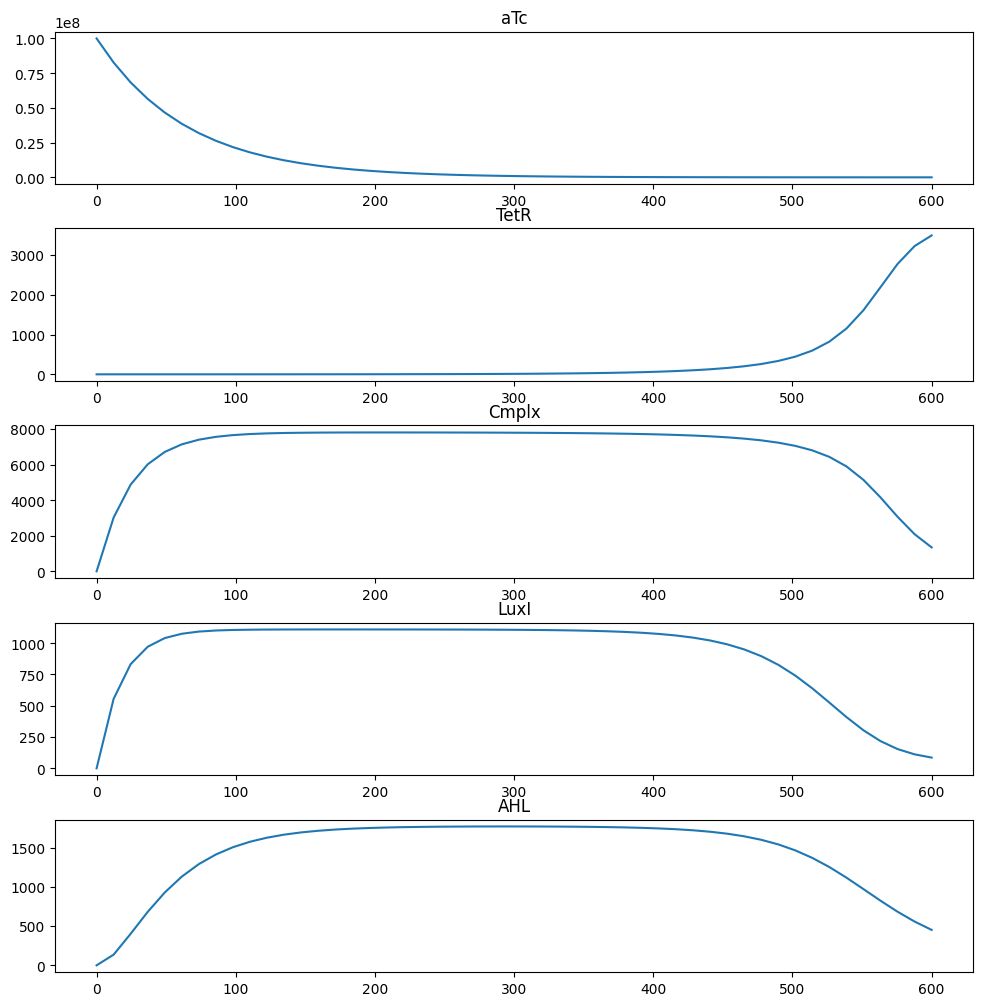

In [41]:
#Time-Scale Single Cell(aTc in molecules)
t=np.linspace(0, 600)
small=1e-45
n=1.5
kd_cmplx=15
kd_ptet=50
k1=k_min_one/kd_cmplx
x0=[10**(8),0,0,0,0] #aTc-TetR-cmplx-LuxI-AHL
solution=odeint(single_cell,x0,t)
fig,axs=plt.subplots(5,figsize=(10,10))
fig.tight_layout()
axs[0].plot(t,solution[:,0])
axs[0].set_title('aTc')
axs[1].plot(t,solution[:,1])
axs[1].set_title('TetR')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Cmplx')
axs[3].plot(t,solution[:,3])
axs[3].set_title('LuxI')
axs[4].plot(t,solution[:,4])
axs[4].set_title('AHL')
ahl_for_fit=molar(solution[:,4])
print(molar(solution[:,4]))

[-3.48779203e-13  4.37209927e-10 -2.03317107e-07  4.09048002e-05
 -9.62385076e-05]
            4             3             2
-3.488e-13 x + 4.372e-10 x - 2.033e-07 x + 4.09e-05 x - 9.624e-05


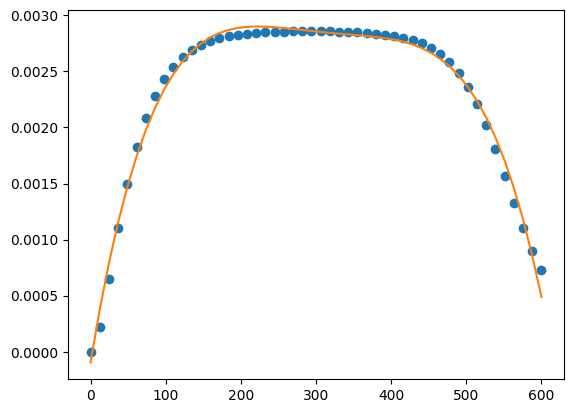

In [43]:
coeffs = np.polyfit(t, ahl_for_fit, 4)
print(coeffs)
poly=np.poly1d(coeffs)
print(poly)
t_poly=t
ahl_poly=poly(t_poly)
plt.plot(t, ahl_for_fit, "o", t_poly, ahl_poly)

Text(0.5, 1.0, 'AHL_ext')

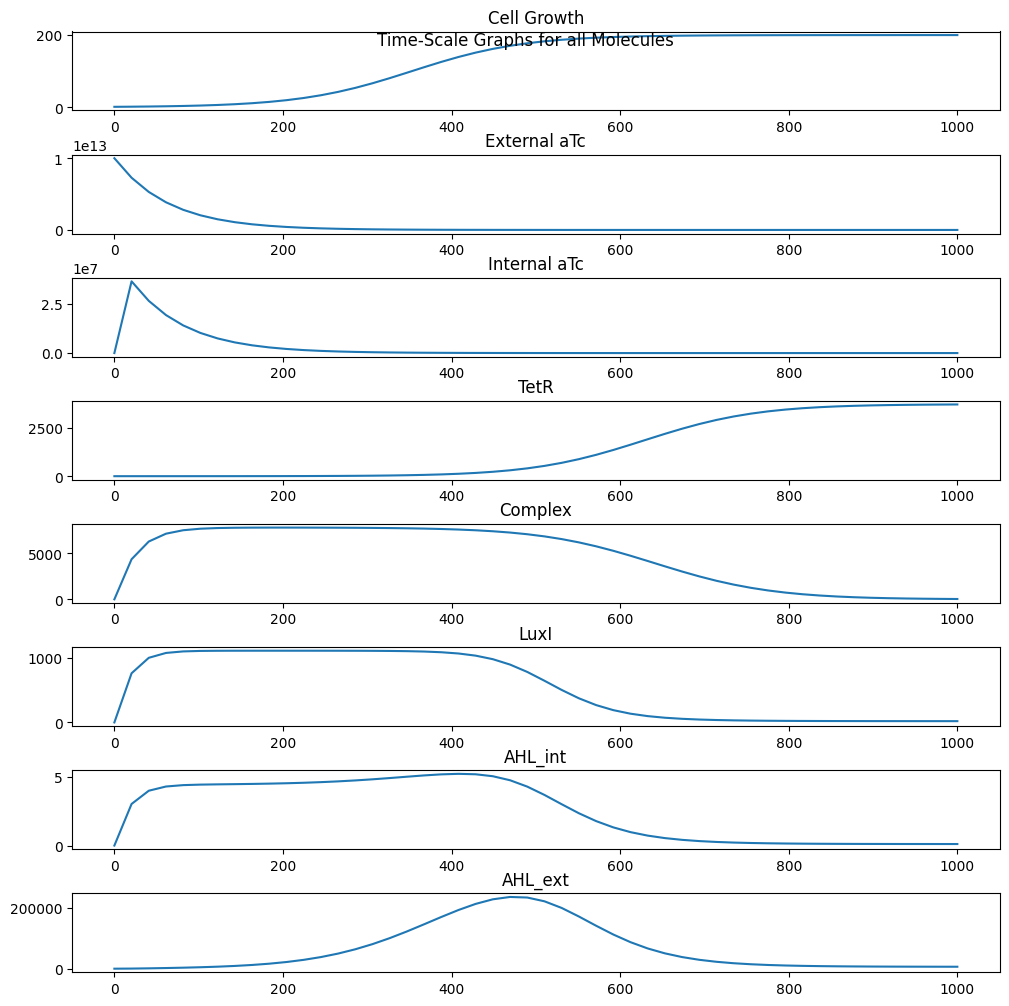

In [12]:
#Time-Scale Whole Cell(aTc in molecules)
small=1e-45
n=2
kd_cmplx=15
kd_ptet=50
k1=k_min_one/kd_cmplx
x0=[1,10**(13),0,0,0,0,0,0] #N-aTc_ext-aTc_int-TetR-LuxI-AHL_int-AHL_ext
solution=odeint(whole_cell,x0,t)
fig,axs=plt.subplots(8,figsize=(10,10))
fig.tight_layout()
plt.suptitle('Time-Scale Graphs for all Molecules')
axs[0].plot(t,solution[:,0])
axs[0].set_title('Cell Growth')
axs[1].plot(t,solution[:,1])
axs[1].set_title('External aTc')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Internal aTc')
axs[3].plot(t,solution[:,3])
axs[3].set_title('TetR')
axs[4].plot(t,solution[:,4])
axs[4].set_title('Complex')
axs[5].plot(t,solution[:,5])
axs[5].set_title('LuxI')
axs[6].plot(t,solution[:,6])
axs[6].set_title('AHL_int')
axs[7].plot(t,solution[:,7])
axs[7].set_title('AHL_ext')

(200,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


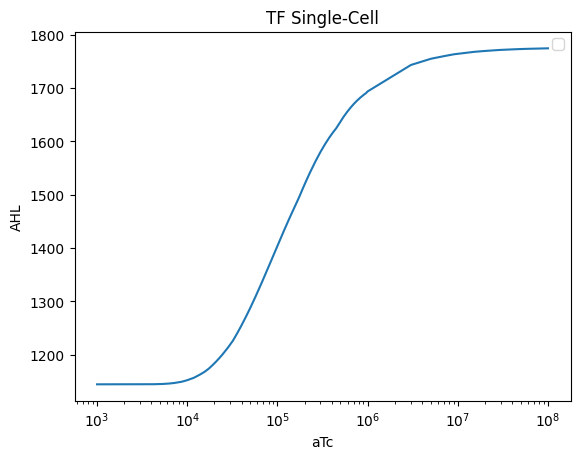

In [6]:
small=1e-45
n=2
kd_cmplx=150#10**(-9)
kd_ptet=500#10**(-9)
k1=k_min_one/kd_cmplx
aTc_values_0=np.linspace(10**(3),10**(4))
aTc_values_1=np.linspace(10**(4),10**(5))
aTc_values_2=np.linspace(10**(5),10**(6))
aTc_values_3=np.linspace(10**(6),10**(8))
#aTc_values_4=np.linspace(10**(6),10**(7))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3])
AHL_temp=[]
print(np.shape(aTc_values))
for i in range(int(np.shape(aTc_values)[0])):
    x0=[aTc_values[i],0,0,0,0] #LuxR-Mon-Dim-mng
    solution=odeint(single_cell,x0,t)
    AHL_temp.append(max(solution[:,4]))
plt.semilogx(aTc_values,AHL_temp)
plt.xlabel('aTc')
plt.ylabel('AHL')
plt.title('TF Single-Cell')
plt.legend()
plt.show()

C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


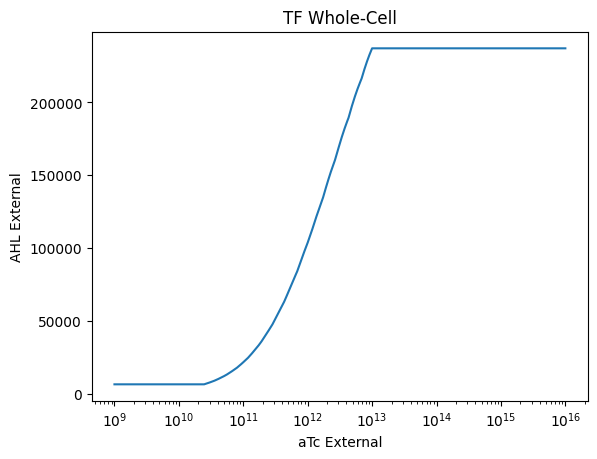

In [7]:
small=1e-45
n=2
kd_cmplx=15
kd_ptet=50
k1=k_min_one/kd_cmplx
aTc_values_0=np.linspace(10**(9),10**(10))
aTc_values_1=np.linspace(10**(10),10**(11))
aTc_values_2=np.linspace(10**(11),10**(12))
aTc_values_3=np.linspace(10**(12),10**(13))
aTc_values_4=np.linspace(10**(13),10**(16),10)
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3,aTc_values_4])
AHL_temp=[]
for i in range(int(np.shape(aTc_values)[0])):
    x0=[1,aTc_values[i],0,0,0,0,0,0] #LuxR-Mon-Dim-mng
    solution=odeint(whole_cell,x0,t)
    AHL_temp.append(max(solution[:,7]))
plt.semilogx(aTc_values,AHL_temp)
plt.xlabel('aTc External')
plt.ylabel('AHL External')
plt.title('TF Whole-Cell')
plt.show()

In [8]:
d_egfp=0.056*60
d_mrnaegfp=0.062*60

def model_fit(x,t): 
    N=x[0]
    aTc_ext=x[1]
    aTc_int=x[2]
    TetR=x[3]
    cmplx=x[4]
    LuxI=x[5]
    eGFP=x[6]
    AHL=x[7]
    
    dNdt=small+mi*N*(1-(N/Nmax))
    daTc_extdt=small+D_aTc*N*(aTc_int-Vc*aTc_ext)-(d_aTc+mi)*aTc_ext
    daTc_intdt=small+D_aTc*(Vc*aTc_ext-aTc_int)+k_min_one*cmplx-(d_aTc+mi)*aTc_int-k1*aTc_int*TetR
    dTetRdt=small+(p_105*k_034*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc_int-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc_int-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(ptet*kluxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(kd_ptet*CN),n))/((pow(abs(TetR),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI - kA*LuxI
    degfpdt=small+(ptet*kluxi*CN/(d_mrnaegfp+mi))*(b_ptet+(1-b_ptet)*((pow(abs(kd_ptet*CN),n))/((pow(abs(TetR),n))+(pow(kd_ptet*CN,n))))) - (d_egfp+mi)*eGFP 
    dAHLdt=small+kA*LuxI-(d_ahl+mi)*AHL

    return [dNdt,daTc_extdt,daTc_intdt,dTetRdt,dcmplxdt,dLuxIdt,degfpdt,dAHLdt]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


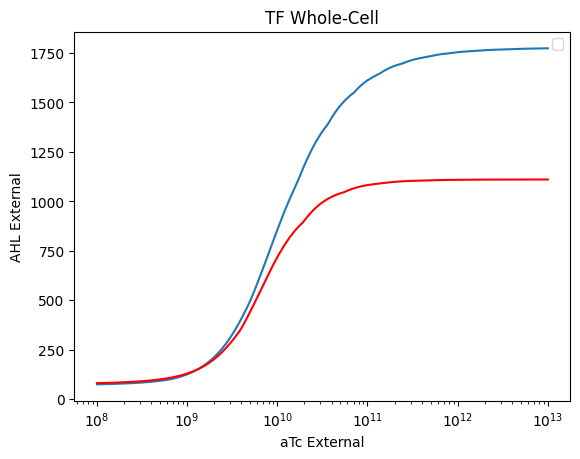

In [10]:
#gia model fit
small=1e-45
d_egfp=0.056
d_mrnaegfp=0.062
n=2
kd_cmplx=15
kd_ptet=50
k1=k_min_one/kd_cmplx
aTc_values_0=np.linspace(10**(8),10**(9))
aTc_values_1=np.linspace(10**(9),10**(10))
aTc_values_2=np.linspace(10**(10),10**(11))
aTc_values_3=np.linspace(10**(11),10**(12))
aTc_values_4=np.linspace(10**(12),10**(13))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3,aTc_values_4])
AHL_temp=[]
luxi_temp=[]
egfp_temp=[]
for i in range(int(np.shape(aTc_values)[0])):
    x0=[1,aTc_values[i],0,0,0,0,0,0] #LuxR-Mon-Dim-mng
    solution=odeint(model_fit,x0,t)
    AHL_temp.append(max(solution[:,7]))
    egfp_temp.append(max(solution[:,6]))
    luxi_temp.append(max(solution[:,5]))
plt.semilogx(aTc_values,AHL_temp)
plt.xlabel('aTc External')
plt.ylabel('AHL External')
plt.title('TF Whole-Cell')
plt.semilogx(aTc_values, luxi_temp,color='red')
#plt.semilogx(aTc_values, egfp_temp,color='green')
plt.legend()
plt.show()
plt.show()